<a href="https://colab.research.google.com/github/thc1006/FLORA/blob/main/0630_FLORA_DP_L4_client_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Cell 1: 環境設定與函式庫匯入（修正版）
!pip install --upgrade opacus -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- 環境設定 ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("✅ Cell 1: 環境與函式庫準備就緒。")
import opacus
print(f"PyTorch/Opacus 版本: {torch.__version__} / {opacus.__version__}")
print(f"CUDA 是否可用: {torch.cuda.is_available()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
✅ Cell 1: 環境與函式庫準備就緒。
PyTorch/Opacus 版本: 2.6.0+cu124 / 1.5.4
CUDA 是否可用: True


In [2]:
# @title Cell 2: 🎓 實驗參數設定（最終驗證版）
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 20
    client_pairs: tuple = ((1, 2), (3, 7), (5, 6))
    num_clients: int = 3
    num_clients_to_select: int = 3

    # L4 GPU 性能與DP穩定性平衡的參數
    local_episodes_per_round: int = 6
    steps_per_episode: int = 300
    batch_size: int = 64                   # <-- 保持大批次以利用GPU
    gamma: float = 0.99

    # 學習參數
    lr: float = 1e-4
    target_update_freq: int = 15

    # RL 探索參數
    epsilon_start: float = 1.0; epsilon_decay: float = 0.9995; epsilon_min: float = 0.05

    # 記憶與回放（L4性能優化）
    memory_capacity: int = 50000           # <-- 保持大容量
    replay_start_size: int = 1000
    replay_frequency: int = 2
    replay_batches_per_call: int = 2

    # 聯邦學習策略參數
    fedprox_mu: float = 0.01
    num_clusters: int = 2
    cluster_update_freq: int = 15

    # 差分隱私參數（RDP會計器穩定配置）
    enable_dp: bool = True
    dp_target_epsilon: float = 8.0         # <-- 使用一個更為標準的隱私預算
    dp_target_delta: float = 1e-5          # <-- 標準的delta值
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 0.7       # <-- 穩定的噪聲乘數
    dp_sampling_probability: float = 0.05
    dp_virtual_batch_size: int = 64
    dp_microbatch_size: int = 1

    # 功能開關
    enable_heterogeneity: bool = True
    enable_compression: bool = True

    # 系統設定
    straggler_ratio: float = 0.1; dropout_ratio: float = 0.05
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True; local_finetune_episodes: int = 15
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    def __post_init__(self):
        if torch.cuda.is_available():
            if "L4" in torch.cuda.get_device_name(0):
                print(f"🚀 L4 GPU檢測到，啟用DP性能優化配置")

        if self.mode == 'Centralized':
            self.enable_dp = False

        if self.enable_dp and self.mode != 'Centralized':
            print(f"🛡️ 差分隱私已啟用（RDP會計器穩定配置）")
        else:
            print(f"🛡️ 差分隱私：禁用（模式: {self.mode}）")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("✅ Cell 2: TrainingConfig（最終驗證版）定義完成。")


✅ Cell 2: TrainingConfig（最終驗證版）定義完成。


In [3]:
# @title Cell 3: 🧩 數據與環境準備（修正版）
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] 正在從 {data_path} 讀取數據...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\[\]\(\)%\s\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 啟動前預檢查 " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"✅ 清理後的欄位列表 (共 {len(cols)} 個):")
        print(f"   - 吞吐量欄位成功匹配: '{self.tput_col}'" if self.tput_col
              else "   - 吞吐量欄位匹配失敗！")
        print(f"   - 延遲/緩衝區欄位成功匹配: '{self.lat_col}'" if self.lat_col
              else "   - 延遲/緩衝區欄位匹配失敗！")

        # 修正：檢查BS節點的實際可用性
        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - 可用BS節點: {available_bs}")

        # 驗證客戶端配對的有效性
        for i, (embb_bs, urllc_bs) in enumerate(self.client_pairs_config):
            if embb_bs not in available_bs or urllc_bs not in available_bs:
                raise ValueError(f"客戶端 {i} 的BS配對 ({embb_bs}, {urllc_bs}) 中包含不存在的BS節點")
        print("   - 客戶端BS配對驗證通過")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("預檢查失敗: 找不到必要的數據欄位。")

    def _get_clean_df(self, gnb_id, slice_id):
        """修正版：增加更嚴格的數據過濾和驗證"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        # 確保數據類型一致性
        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        # 修正：更嚴格的數據清理
        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        # 移除異常值（超出合理範圍的數據點）
        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &  # 吞吐量範圍
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)  # 延遲範圍
            ]

        return subset

    def get_client_trajectories(self):
        """修正版：確保客戶端數據完全獨立"""
        client_trajectories = {}
        print("[DataManager] 正在為每個客戶端生成數據軌跡...")

        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="處理客戶端數據")):
            try:
                # 確保每個客戶端使用不同的BS，維護數據獨立性
                df_embb = self._get_clean_df(embb_id, 0)  # eMBB切片
                df_urllc = self._get_clean_df(urllc_id, 2)  # URLLC切片

                if df_embb.empty or df_urllc.empty:
                    print(f"🟡 警告: 客戶端 {i} (BS {embb_id}/{urllc_id}) 篩選後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 修正：使用更保守的時間容忍度，避免數據洩漏
                merged_df = pd.merge_asof(
                    df_embb.sort_values('timestamp'),
                    df_urllc.sort_values('timestamp'),
                    on='timestamp',
                    direction='backward',  # 確保只使用過去的信息
                    tolerance=pd.Timedelta('100ms'),  # 減少容忍度
                    suffixes=('_embb', '_urllc')
                ).dropna()

                if merged_df.empty:
                    print(f"🟡 警告: 客戶端 {i} 合併後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 確保數據序列的時間順序性
                merged_df = merged_df.sort_values('timestamp').reset_index(drop=True)
                trajectory = merged_df[['throughput_embb', 'latency_embb',
                                      'throughput_urllc', 'latency_urllc']].to_numpy(dtype=np.float32)

                client_trajectories[i] = trajectory
                print(f"   - 客戶端 {i}: {len(trajectory)} 個時間步")

            except Exception as e:
                print(f"❌ 錯誤: 處理客戶端 {i} 時發生嚴重錯誤: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 數據處理完成！成功為 {num_valid} / {len(self.client_pairs_config)} 個客戶端創建了環境。")
        return client_trajectories

print("✅ Cell 3: DataManager（修正版）定義完成。")


✅ Cell 3: DataManager（修正版）定義完成。


In [4]:
# @title Cell 4: ⚡ RL 環境與數據處理（整合GPU設定）
import gc
import time
import os
import torch
import numpy as np
import pandas as pd
from collections import deque
from torch.utils.data import Dataset, DataLoader

class PairedEnv:
    # ... PairedEnv 類別的程式碼保持不變 ...
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3; self.cursor = 0; self.reset()

    def reset(self):
        if self.trajectory.size == 0: return np.zeros(self.state_size, dtype=np.float32)
        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0: self.cursor = np.random.randint(0, max_start)
        else: self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}
        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        tput_embb, lat_embb, tput_urllc, lat_urllc = state
        if action_id == 0: w_tput, w_lat = (0.7, 0.3)
        elif action_id == 2: w_tput, w_lat = (0.3, 0.7)
        else: w_tput, w_lat = (0.5, 0.5)
        tput_reward = w_tput * (np.log1p(tput_embb) + 0.5 * np.log1p(tput_urllc))
        lat_penalty = w_lat * (np.tanh(lat_urllc * 1e-6) + 0.3 * np.tanh(lat_embb * 1e-6))
        reward_val = tput_reward - lat_penalty
        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    # ... RLDataset 類別的程式碼保持不變 ...
    def __init__(self, memory_list): self.data = memory_list[:]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (torch.from_numpy(state).float(), torch.tensor(action).long(),
                torch.tensor(reward).float(), torch.from_numpy(next_state).float(),
                torch.tensor(done).bool())

def get_gpu_optimized_data_loader(agent_memory: deque, batch_size: int, device: str):
    # ... get_gpu_optimized_data_loader 函數的程式碼保持不變 ...
    if len(agent_memory) < batch_size: return None
    try:
        dataset = RLDataset(list(agent_memory))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    except Exception as e:
        print(f"🚨 GPU優化DataLoader創建失敗: {e}")
        return None

# ==============================================================================
# 關鍵修正：將所有GPU設定邏輯整合到一個函數中，並放在此處
# ==============================================================================
def setup_gpu_environment():
    """統一的GPU環境設定函數，智能檢測L4並應用最佳設定"""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

        if "L4" in gpu_name:
            # L4 GPU 使用性能優先的設定
            torch.cuda.set_per_process_memory_fraction(0.9) # 使用90%記憶體
            print(f"🚀 L4 GPU檢測到，性能優先設定：使用90%記憶體 ({total_memory:.1f} GB)")
            os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024,expandable_segments:True"
        else:
            # 其他GPU使用較保守的設定
            torch.cuda.set_per_process_memory_fraction(0.8) # 使用80%記憶體
            print(f"🎮 標準GPU檢測到，保守設定：使用80%記憶體 ({total_memory:.1f} GB)")
            os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512,expandable_segments:True"

        torch.cuda.empty_cache()
        gc.collect()
        print(f"🧹 GPU環境設定完成")
    else:
        print("⚠️ 未檢測到GPU，將使用CPU模式運行。")

print("✅ Cell 4: RL環境與數據處理（整合GPU設定）定義完成。")


✅ Cell 4: RL環境與數據處理（整合GPU設定）定義完成。


In [5]:
# @title Cell 5: 🛡️ 核心學習代理（差分隱私最終驗證版）
import gc
import time
from opacus import PrivacyEngine
from opacus.accountants import RDPAccountant # <-- 明確導入RDP會計器
from opacus.validators import ModuleValidator

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params = None
        self.is_eval_agent = is_eval_agent
        self.privacy_engine = None
        self.dp_steps = 0
        self.current_epsilon = 0.0
        self.consecutive_errors = 0
        self.max_consecutive_errors = 5

        self.model = self._build_dp_model()
        self.target_model = self._build_dp_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._initialize_dp_engine()
        else:
            print(f"[C-{self.client_id}] 🛡️ 標準模式（無差分隱私）")

    def _build_dp_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, self.action_size)
        ).to(self.device)
        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)
        return model

    def _initialize_dp_engine(self):
        """最終驗證版：明確使用RDP會計器"""
        print(f"[C-{self.client_id}] 🛡️ 初始化差分隱私引擎...")
        try:
            dummy_data = []
            for _ in range(self.config.batch_size * 2):
                state = np.random.randn(self.state_size).astype(np.float32)
                action = int(np.random.randint(0, 3))
                reward = float(np.random.randn())
                next_state = np.random.randn(self.state_size).astype(np.float32)
                done = bool(np.random.choice([True, False]))
                dummy_data.append((state, action, reward, next_state, done))

            dummy_dataset = RLDataset(dummy_data)
            dummy_loader = DataLoader(
                dummy_dataset, batch_size=self.config.batch_size, num_workers=0
            )

            # 關鍵修正：明確指定使用RDP會計器
            self.privacy_engine = PrivacyEngine(accountant="rdp")

            self.model, self.optimizer, dummy_loader = self.privacy_engine.make_private(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=dummy_loader,
                noise_multiplier=self.config.dp_noise_multiplier,
                max_grad_norm=self.config.dp_max_grad_norm,
                poisson_sampling=False
            )
            print(f"   - ✅ 差分隱私引擎初始化成功（使用RDP會計器）")
        except Exception as e:
            print(f"   - ❌ 差分隱私初始化失敗: {e}")
            self.privacy_engine = None

    def replay(self, num_batches: int):
        if len(self.memory) < self.config.batch_size: return 0.0

        data_loader = get_gpu_optimized_data_loader(
            self.memory, self.config.batch_size, self.device
        )
        if data_loader is None: return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        try:
            for i, batch in enumerate(data_loader):
                if i >= num_batches: break

                self.optimizer.zero_grad()
                states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]

                current_q = self.model(states).gather(1, actions.view(-1, 1))
                with torch.no_grad():
                    max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards.view(-1, 1) + (self.gamma * max_next_q * (~dones.view(-1, 1)))

                loss = self.criterion(current_q, target_q)

                if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                    proximal_term = 0.0
                    model_params = self.model._module.parameters() if hasattr(self.model, '_module') else self.model.parameters()
                    for local_param, global_param in zip(model_params, self.global_params):
                        proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                    loss += (self.mu / 2) * proximal_term

                if not torch.isfinite(loss): continue

                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                batches_processed += 1
                if self.privacy_engine: self.dp_steps += 1

            return total_loss / batches_processed if batches_processed > 0 else 0.0
        except Exception as e:
            print(f"[C-{self.client_id}] 🚨 回放錯誤: {e}")
            return 0.0

    def get_privacy_cost(self):
        """最終驗證版：安全的隱私成本獲取"""
        if self.privacy_engine:
            try:
                epsilon = self.privacy_engine.get_epsilon(self.config.dp_target_delta)
                # 關鍵修正：檢查inf或nan值
                if np.isinf(epsilon) or np.isnan(epsilon):
                    print(f"[C-{self.client_id}] ⚠️ 檢測到無效的epsilon值({epsilon})，返回0")
                    return 0.0
                return epsilon
            except Exception as e:
                print(f"[C-{self.client_id}] ⚠️ 隱私成本計算失敗: {e}")
                return 0.0
        return 0.0

    # ... 其餘方法 remember, set_global_params 等保持不變 ...
    def remember(self, *args): self.memory.append(args)
    def set_global_params(self, state_dict):
        with torch.no_grad(): self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]
    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon: return random.randrange(self.action_size)
        with torch.no_grad(): q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()
    def get_clean_state_dict(self):
        return self.model._module.state_dict() if self.privacy_engine and hasattr(self.model, '_module') else self.model.state_dict()
    def update_target_model(self): self.target_model.load_state_dict(self.get_clean_state_dict())
    def get_model_weights_flat(self):
        with torch.no_grad():
            params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()
    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        return {k: v.half() for k, v in state_dict.items()} if self.config.enable_compression else state_dict

# 保持 Cell 4 中定義的 GPU 優化版 DataLoader
def get_gpu_optimized_data_loader(agent_memory: deque, batch_size: int, device: str):
    if len(agent_memory) < batch_size: return None
    try:
        dataset = RLDataset(list(agent_memory))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    except Exception as e:
        print(f"🚨 GPU優化DataLoader創建失敗: {e}")
        return None

# 保持 Cell 4 中定義的 RLDataset
class RLDataset(Dataset):
    def __init__(self, memory_list): self.data = memory_list[:]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (torch.from_numpy(state).float(), torch.tensor(action).long(), torch.tensor(reward).float(), torch.from_numpy(next_state).float(), torch.tensor(done).bool())

print("✅ Cell 5: RLAgent（差分隱私最終驗證版）定義完成。")


✅ Cell 5: RLAgent（差分隱私最終驗證版）定義完成。


In [6]:
# @title Cell 6: 📡 聯邦學習伺服器（差分隱私增強版）
class FLServer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.client_to_cluster = {}
        self.cluster_models = {}

        # 差分隱私增強：添加隱私相關記錄
        self.clustering_history = []
        self.aggregation_history = []
        self.dp_enabled = config.enable_dp and config.mode != 'Centralized'

        if self.dp_enabled:
            print(f"🛡️ FLServer: 差分隱私模式已啟用")
            print(f"   - 目標隱私預算: ε={config.dp_target_epsilon}")
            print(f"   - 聚合策略: 加權平均（DP兼容）")

    @torch.no_grad()
    def aggregate_weighted(self, client_updates: list[tuple[dict, int]]):
        """差分隱私兼容的加權聚合"""
        if not client_updates:
            return None

        # 差分隱私增強：記錄聚合統計信息
        if self.dp_enabled:
            num_participants = len(client_updates)
            total_data_points = sum(num_points for _, num_points in client_updates)
            print(f"🔒 DP聚合: {num_participants} 個客戶端，總數據點: {total_data_points}")

        # 解壓縮模型（如果需要）
        decompressed_updates = []
        for state_dict, num_points in client_updates:
            if (self.config.enable_compression and
                next(iter(state_dict.values())).dtype == torch.float16):
                state_dict = {k: v.float() for k, v in state_dict.items()}
            decompressed_updates.append((state_dict, num_points))

        total_data_points = sum(num_points for _, num_points in decompressed_updates)
        if total_data_points == 0:
            return copy.deepcopy(decompressed_updates[0][0])

        # 差分隱私兼容的加權聚合
        global_dict = {k: torch.zeros_like(v, device='cpu')
                      for k, v in decompressed_updates[0][0].items()}

        for state_dict, num_points in decompressed_updates:
            weight = num_points / total_data_points
            for k, v in state_dict.items():
                global_dict[k] += v.cpu() * weight

        # 差分隱私增強：記錄聚合歷史（用於分析）
        if self.dp_enabled:
            self.aggregation_history.append({
                'timestamp': time.time(),
                'num_participants': len(client_updates),
                'total_data_points': total_data_points,
                'weights': [num_points / total_data_points for _, num_points in decompressed_updates]
            })

        return global_dict

    def distribute_model(self, agents: dict, global_model_state: dict):
        """差分隱私安全的模型分發"""
        if not global_model_state:
            return

        # 差分隱私增強：檢查模型狀態有效性
        if self.dp_enabled:
            # 檢查模型參數是否包含異常值（可能由DP噪聲引起）
            param_stats = self._check_model_sanity(global_model_state)
            if param_stats['has_inf'] or param_stats['has_nan']:
                print(f"⚠️ DP警告: 檢測到模型參數異常，可能由差分隱私噪聲引起")

        for cid, agent in agents.items():
            current_model_state = global_model_state

            # 使用歷史聚類信息，避免未來信息洩漏
            if self.config.mode == 'ClusteredFL':
                cluster_id = self.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.cluster_models:
                    current_model_state = self.cluster_models[cluster_id]

            # 差分隱私安全的模型載入
            try:
                agent.model.load_state_dict(current_model_state, strict=False)
                agent.set_global_params(current_model_state)
            except Exception as e:
                print(f"⚠️ 客戶端 {cid} 模型載入失敗: {e}")

    def _check_model_sanity(self, model_state: dict):
        """檢查模型參數的有效性（DP噪聲可能導致異常值）"""
        has_nan = any(torch.isnan(param).any() for param in model_state.values())
        has_inf = any(torch.isinf(param).any() for param in model_state.values())

        param_norms = [torch.norm(param).item() for param in model_state.values()]
        max_norm = max(param_norms) if param_norms else 0.0

        return {
            'has_nan': has_nan,
            'has_inf': has_inf,
            'max_param_norm': max_norm
        }

    def update_clusters(self, agents: dict, current_round: int):
        """差分隱私兼容的聚類更新"""
        if len(agents) < self.config.num_clusters:
            return

        print(f"\n[分群] 正在為 {len(agents)} 個客戶端重新計算群組（回合 {current_round}）...")

        # 差分隱私增強：聚類前的隱私檢查
        if self.dp_enabled:
            print(f"🔒 DP聚類: 使用差分隱私訓練後的模型權重進行聚類")

        client_ids = list(agents.keys())

        try:
            # 使用當前回合之前的模型權重進行聚類
            weight_vectors = np.array([agents[cid].get_model_weights_flat() for cid in client_ids])

            # 差分隱私增強：檢查權重向量有效性
            if np.isnan(weight_vectors).any() or np.isinf(weight_vectors).any():
                print("   - 警告: 模型權重中包含 NaN/Inf，可能由DP噪聲引起，跳過本輪分群。")
                return

            # 差分隱私增強：權重向量標準化（減少DP噪聲影響）
            if self.dp_enabled and weight_vectors.std() > 0:
                weight_vectors = (weight_vectors - weight_vectors.mean()) / weight_vectors.std()

            # 使用固定的random_state確保可重現性
            kmeans = KMeans(
                n_clusters=self.config.num_clusters,
                random_state=self.config.random_seed + current_round,
                n_init=10,
                max_iter=100
            ).fit(weight_vectors)

            # 更新聚類分配
            new_clustering = {client_ids[i]: label for i, label in enumerate(kmeans.labels_)}

            # 記錄聚類變化
            if hasattr(self, 'client_to_cluster') and self.client_to_cluster:
                changes = sum(1 for cid in client_ids
                            if self.client_to_cluster.get(cid, -1) != new_clustering[cid])
                print(f"   - 聚類變更: {changes} 個客戶端")

            self.client_to_cluster = new_clustering

            # 記錄聚類歷史（用於分析，不用於訓練）
            clustering_record = {
                'round': current_round,
                'clustering': copy.deepcopy(new_clustering),
                'dp_enabled': self.dp_enabled
            }
            self.clustering_history.append(clustering_record)

            print("   - ✅ 分群完成。新的群組分配如下:")
            for cluster_id in range(self.config.num_clusters):
                clients_in_cluster = [cid for cid, c_id in self.client_to_cluster.items()
                                    if c_id == cluster_id]
                print(f"     > 群組 {cluster_id}: 客戶端 {clients_in_cluster}")

        except Exception as e:
            print(f"   - 錯誤: 聚類更新失敗: {e}")
            if self.dp_enabled:
                print(f"   - 這可能與差分隱私噪聲有關")

    def get_privacy_statistics(self):
        """獲取差分隱私相關統計信息"""
        if not self.dp_enabled:
            return {"message": "差分隱私未啟用"}

        return {
            "aggregations_performed": len(self.aggregation_history),
            "clustering_updates": len(self.clustering_history),
            "dp_target_epsilon": self.config.dp_target_epsilon,
            "dp_target_delta": self.config.dp_target_delta
        }

print("✅ Cell 6: FLServer（差分隱私增強版）定義完成。")


✅ Cell 6: FLServer（差分隱私增強版）定義完成。


In [7]:
# @title Cell 7: 🚀 ExperimentRunner（超支後繼續執行版）
import scipy.stats as stats
import time
from tqdm.notebook import tqdm
import copy
import numpy as np
import pandas as pd
import os

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []

        # 隱私預算管理初始化
        self.total_privacy_budget = config.dp_target_epsilon if config.enable_dp else 0.0
        self.consumed_privacy_budget = 0.0
        self.privacy_budget_exceeded = False # 標誌位，用於記錄是否已超支

        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")

        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"🛡️ 差分隱私模式啟用：")
            print(f"   - 總隱私預算上限: ε={self.total_privacy_budget}")

        # ... 後續的環境和代理初始化保持不變 ...
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs: raise ValueError("DataManager 未能為任何客戶端創建有效的環境。")
        self.config.num_clients = len(self.client_envs)
        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config); central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size, central_config, 0, len(pooled_trajectory), False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config, cid, dataset_size, False)
        if self.client_agents: self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else: self.global_model_state = self.central_agent.get_clean_state_dict()
        self.config.save()
        print("[ExperimentRunner] 初始化完成。")


    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _check_privacy_budget(self, round_privacy_costs):
        """關鍵修正：將硬停止改為軟警告"""
        if not self.config.enable_dp or self.config.mode == 'Centralized':
            return # 非DP模式無需檢查

        if round_privacy_costs:
            round_consumption = np.mean(round_privacy_costs)
            self.consumed_privacy_budget += round_consumption

            budget_ratio = self.consumed_privacy_budget / self.total_privacy_budget

            # 檢查是否首次超支
            if budget_ratio > 1.0 and not self.privacy_budget_exceeded:
                print(f"\n{'='*20} ⚠️ 隱私預算首次超支！ {'='*20}")
                print(f"   - 當前消耗: ε = {self.consumed_privacy_budget:.4f}")
                print(f"   - 預算上限: ε = {self.total_privacy_budget}")
                print(f"   - 接下來的訓練將不再提供嚴格的差分隱私保證。")
                print(f"{'='*58}")
                self.privacy_budget_exceeded = True # 設置超支標誌，只警告一次

        # 注意：我們移除了 `return False`，讓檢查永遠通過

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        # ... 此函數的內部邏輯保持不變 ...
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0
        if episodes == 0: return 0.0, 0.0, 0.0
        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                if len(agent.memory) > self.config.replay_start_size and step % self.config.replay_frequency == 0:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1
                if done: break
            total_reward += episode_reward
            episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0: agent.update_target_model()
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min: agent.epsilon *= self.config.epsilon_decay
        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and self.config.enable_dp and agent.privacy_engine else 0.0
        return avg_loss, avg_reward, privacy_cost

    def _run_federated_training(self):
        """關鍵修正：移除終止訓練的邏輯"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            # 關鍵修正：移除了對 self.privacy_budget_exceeded 的檢查和 break 語句
            # 即使超支，訓練也會繼續

            # ... 後續的聚類、客戶端選擇、模型分發等邏輯保持不變 ...
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids); straggler_ids = set()
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]
                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0: straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))
            if not participating_ids: continue
            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # 本地訓練並收集隱私成本
            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []
            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids else self.config.local_episodes_per_round)
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)
                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss); round_rewards.append(reward)
                if self.config.enable_dp and privacy_cost > 0: round_privacy_costs.append(privacy_cost)

            # 調用預算檢查函數（現在它只會發出警告，不會停止）
            self._check_privacy_budget(round_privacy_costs)

            # ... 後續的聚合、記錄歷史等邏輯保持不變 ...
            if self.config.mode == 'ClusteredFL':
                # ...
                client_updates_by_cluster = {i: [] for i in range(self.config.num_clusters)}
                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]; cluster_id = self.server.client_to_cluster.get(cid, 0)
                    client_updates_by_cluster[cluster_id].append((model_update, num_points))
                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))
                if new_cluster_models: self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates: self.global_model_state = self.server.aggregate_weighted(client_updates)
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            if self.config.enable_dp:
                if round_privacy_costs:
                    self.privacy_costs.append({'round': comm_round, 'epsilon': np.mean(round_privacy_costs), 'cumulative_epsilon': self.consumed_privacy_budget, 'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget})
                else:
                    self.privacy_costs.append({'round': comm_round, 'epsilon': 0.0, 'cumulative_epsilon': self.consumed_privacy_budget, 'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget})
            postfix = {'reward': f"{avg_reward:.2f}", 'loss': f"{avg_loss:.4f}"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0: postfix['ε_used'] = f"{self.consumed_privacy_budget:.3f}"
            progress_bar.set_postfix(postfix)

    # ... 其他方法 _evaluate_agent, _run_centralized_training, _run_isolated_training, run 等保持不變 ...
    def _evaluate_agent(self, env, model_state, num_episodes=15):
        if env.trajectory.size == 0: return 0.0
        eval_config = copy.deepcopy(self.config); eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, -1, 1, True)
        eval_agent.model.load_state_dict(model_state); eval_agent.model.eval(); eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward; state = next_state
                if done: break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_centralized_training(self):
        print(f"\n[模式] 執行集中式訓練 (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round
        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env, episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'cumulative_epsilon': 0.0, 'budget_ratio': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        print(f"\n[模式] 執行孤立式訓練 (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")
        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))
        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []
            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes=equivalent_episodes_per_client)
                round_rewards.append(reward); round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0: round_epsilons.append(privacy_cost)
            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            if self.config.enable_dp and round_epsilons:
                avg_epsilon = np.mean(round_epsilons)
                self.consumed_privacy_budget += avg_epsilon
                self.privacy_costs.append({'round': r, 'epsilon': avg_epsilon, 'cumulative_epsilon': self.consumed_privacy_budget, 'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget})
            else:
                self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'cumulative_epsilon': self.consumed_privacy_budget, 'budget_ratio': self.consumed_privacy_budget / self.total_privacy_budget})
            postfix = {'reward': f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN", 'loss': f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"}
            if self.config.enable_dp and self.consumed_privacy_budget > 0: postfix['ε_used'] = f"{self.consumed_privacy_budget:.3f}"
            progress_bar.set_postfix(postfix)

    def _run_final_evaluation_and_pfl(self):
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state: torch.save(self.global_model_state, final_model_path)
        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}; seed = self.config.random_seed + cid
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(cid)
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)
            if personalized_model_state is base_model_state: eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config); finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid, len(env.trajectory), False)
                finetune_agent.epsilon = 0.01; finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, True)
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else: eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']
            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} 🏃‍♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()
        if self.config.mode == 'Centralized': self._run_centralized_training()
        elif self.config.mode == 'Isolated': self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']: self._run_federated_training()
        else: raise ValueError(f"未知的實驗模式: {self.config.mode}")
        self._run_final_evaluation_and_pfl()
        total_time = (time.time() - start_time) / 60
        print(f"✅ 實驗 {self.config.experiment_name} 完成！總耗時: {total_time:.2f} 分鐘")
        if self.config.enable_dp and self.config.mode != 'Centralized':
            print(f"🛡️ 最終隱私報告：")
            print(f"   - 總消耗隱私預算: ε = {self.consumed_privacy_budget:.4f}")
            if self.privacy_budget_exceeded: print(f"   - ⚠️ 隱私預算已超支")
            else: print(f"   - ✅ 隱私預算控制良好")
        if self.training_history: pd.DataFrame(self.training_history).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)
        if self.evaluation_results: pd.DataFrame(self.evaluation_results).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)
        if self.config.enable_dp and self.privacy_costs: pd.DataFrame(self.privacy_costs).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)
        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("✅ Cell 7: ExperimentRunner（超支後繼續執行版）定義完成。")


✅ Cell 7: ExperimentRunner（超支後繼續執行版）定義完成。


In [8]:
# @title Cell 8: 🎬 主要執行區塊（修正調用）
import time
import gc
from datetime import datetime

def run_final_dp_experiment(config_dict: dict, data_path: str, all_trajectories, client_pairs):
    start_time = time.time()
    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*15} 🛡️ DP最終實驗: {config.experiment_name} {'='*15}")

        if config.enable_dp and config.mode != 'Centralized':
            print(f"🛡️ 差分隱私: 啟用 (ε={config.dp_target_epsilon})")
        else:
            print(f"🛡️ 差分隱私: 禁用")

        data_manager = DataManager(data_path, config.client_pairs)
        runner = ExperimentRunner(config, data_manager, all_trajectories, client_pairs)

        eval_res, history_res = runner.run()

        execution_time = (time.time() - start_time) / 60
        print(f"⏱️ 完成時間: {execution_time:.2f} 分鐘")
        print(f"✅ 結果:")
        print(eval_res.round(2))

        if config.enable_dp and config.mode != 'Centralized':
            # ... 隱私成本報告邏輯保持不變 ...
            try:
                total_privacy_cost = 0.0
                for agent in runner.client_agents.values():
                    cost = agent.get_privacy_cost()
                    total_privacy_cost += cost
                print(f"🛡️ 總隱私成本: ε ≈ {total_privacy_cost:.4f}")
                if total_privacy_cost <= config.dp_target_epsilon: print(f"✅ 隱私預算控制良好")
                else: print(f"⚠️ 隱私預算超支")
            except Exception as e:
                print(f"⚠️ 隱私成本計算失敗: {e}")

        del runner, data_manager
        torch.cuda.empty_cache()
        gc.collect()
        return True
    except Exception as e:
        execution_time = (time.time() - start_time) / 60
        print(f"❌ 實驗失敗: {config_dict.get('experiment_name')}")
        print(f"⏱️ 失敗時間: {execution_time:.2f} 分鐘")
        print(f"🔍 錯誤: {str(e)[:150]}...")
        torch.cuda.empty_cache()
        gc.collect()
        return False

# ==============================================================================
# 關鍵修正：調用在 Cell 4 中定義的正確函數
# ==============================================================================
setup_gpu_environment()

# 環境設定
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
print(f"✅ 數據路徑: {DATA_PATH}")

# 實驗設定
MODES_TO_RUN = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]
SEEDS = [42]
BASE_CLIENT_PAIRS = ((1, 2), (3, 7), (5, 6))
NUM_TOTAL_CLIENTS = len(BASE_CLIENT_PAIRS)
print(f"✅ DP實驗設定: {MODES_TO_RUN}")

# 數據準備
print(f"\n[數據準備] 準備 {NUM_TOTAL_CLIENTS} 個客戶端數據...")
data_manager = DataManager(DATA_PATH, BASE_CLIENT_PAIRS)
original_trajectories = data_manager.get_client_trajectories()
print(f"✅ {len(original_trajectories)} 個客戶端數據準備完成")

# 執行實驗
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_dp_final_stable")
total_start_time = time.time()
successful_experiments = 0
total_experiments = len(SEEDS) * len(MODES_TO_RUN)
print(f"\n🚀 開始DP最終實驗 (總共 {total_experiments} 個)...")

for seed in SEEDS:
    for mode in MODES_TO_RUN:
        exp_name = f"{mode}_dp_final"
        output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)
        config_params = {
            "experiment_name": exp_name, "output_dir": output_dir, "mode": mode, "random_seed": seed,
            "client_pairs": BASE_CLIENT_PAIRS, "num_clients": NUM_TOTAL_CLIENTS, "num_clients_to_select": NUM_TOTAL_CLIENTS,
            "comm_rounds": 20, "local_episodes_per_round": 5, "steps_per_episode": 250, "num_clusters": 2,
            "enable_dp": True, "dp_target_epsilon": 15.0, "dp_target_delta": 1e-3, "dp_noise_multiplier": 1.0, "dp_max_grad_norm": 0.5,
            "batch_size": 8, "memory_capacity": 15000, "lr": 5e-5, "replay_frequency": 1, "replay_batches_per_call": 1,
        }
        print(f"\n--- DP實驗 {successful_experiments+1}/{total_experiments}: {mode} ---")
        success = run_final_dp_experiment(config_params, DATA_PATH, original_trajectories, BASE_CLIENT_PAIRS)
        if success: successful_experiments += 1
        print(f"✅ {mode} 成功" if success else f"❌ {mode} 失敗")
        torch.cuda.empty_cache(); gc.collect(); time.sleep(3)

total_time = (time.time() - total_start_time) / 60
success_rate = (successful_experiments / total_experiments) * 100
print(f"\n{'='*50}")
print(f"🎉 差分隱私實驗完成！")
print(f"⏱️ 總時間: {total_time:.2f} 分鐘")
print(f"✅ 成功率: {success_rate:.1f}% ({successful_experiments}/{total_experiments})")
print(f"🛡️ 隱私保護: 聯邦模式已整合差分隱私")
print(f"{'='*50}")


🎮 標準GPU檢測到，保守設定：使用80%記憶體 (15.8 GB)
🧹 GPU環境設定完成
Mounted at /content/drive
✅ 數據路徑: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
✅ DP實驗設定: ['Centralized', 'Isolated', 'FedAvg', 'FedProx', 'ClusteredFL']

[數據準備] 準備 3 個客戶端數據...

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過

[DataManager] 正在為每個客戶端生成數據軌跡...


處理客戶端數據:   0%|          | 0/3 [00:00<?, ?it/s]

   - 客戶端 0: 10568 個時間步
   - 客戶端 1: 6918 個時間步
   - 客戶端 2: 8756 個時間步

[DataManager] 數據處理完成！成功為 3 / 3 個客戶端創建了環境。
✅ 3 個客戶端數據準備完成

🚀 開始DP最終實驗 (總共 5 個)...

--- DP實驗 1/5: Centralized ---
🛡️ 差分隱私：禁用（模式: Centralized）

=============== 🛡️ DP最終實驗: Centralized_dp_final ===============
🛡️ 差分隱私: 禁用

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - 客戶端BS配對驗證通過


[ExperimentRunner] 正在初始化客戶端環境與代理...
[C-0] 🛡️ 標準模式（無差分隱私）
[ExperimentRunner] 初始化完成。

==================== 🏃‍♂️ 開始執行實驗: Centralized_dp_final (Centralized) ====================

[模式] 執行集中式訓練 (Centralized)


Centralized Training:   0%|          | 0/20 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 Centralized_dp_final 完成！總耗時: 6.94 分鐘
⏱️ 完成時間: 7.03 分鐘
✅ 結果:
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         102.76               102.76                173.37
1          1          87.27                87.27                119.57
2          2          87.67                87.67                184.04
✅ Centralized 成功

--- DP實驗 2/5: Isolated ---
🛡️ 差分隱私已啟用（RDP會計器穩定配置）

=============== 🛡️ DP最終實驗: Isolated_dp_final ===============
🛡️ 差分隱私: 啟用 (ε=15.0)

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'
   - 可用BS節點: [np.int64(1), np.int64(2),

Isolated Training Rounds:   0%|          | 0/20 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 Isolated_dp_final 完成！總耗時: 10.36 分鐘
🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 39133.7727
   - ✅ 隱私預算控制良好
⏱️ 完成時間: 10.44 分鐘
✅ 結果:
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         214.94               214.94                158.22
1          1         135.28               135.28                 86.39
2          2         135.97               135.97                186.46
🛡️ 總隱私成本: ε ≈ 11438.5739
⚠️ 隱私預算超支
✅ Isolated 成功

--- DP實驗 3/5: FedAvg ---
🛡️ 差分隱私已啟用（RDP會計器穩定配置）

=============== 🛡️ DP最終實驗: FedAvg_dp_final ===============
🛡️ 差分隱私: 啟用 (ε=15.0)

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   

FedAvg Training:   0%|          | 0/20 [00:00<?, ?it/s]


==================== ⚠️ 隱私預算首次超支！ ====================
   - 當前消耗: ε = 68.6712
   - 預算上限: ε = 15.0
   - 接下來的訓練將不再提供嚴格的差分隱私保證。
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 FedAvg_dp_final 完成！總耗時: 10.81 分鐘
🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 39133.7727
   - ⚠️ 隱私預算已超支
⏱️ 完成時間: 10.89 分鐘
✅ 結果:
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         151.73               151.73                151.73
1          1         129.28               129.28                 83.24
2          2         133.25               133.25                 81.30
🛡️ 總隱私成本: ε ≈ 11438.5739
⚠️ 隱私預算超支
✅ FedAvg 成功

--- DP實驗 4/5: FedProx ---
🛡️ 差分隱私已啟用（RDP會計器穩定配置）

=============== 🛡️ DP最終實驗: FedProx_dp_final ===============
🛡️ 差分隱私: 啟用 (ε=15.0)

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 

FedProx Training:   0%|          | 0/20 [00:00<?, ?it/s]


==================== ⚠️ 隱私預算首次超支！ ====================
   - 當前消耗: ε = 68.6712
   - 預算上限: ε = 15.0
   - 接下來的訓練將不再提供嚴格的差分隱私保證。
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242

[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 FedProx_dp_final 完成！總耗時: 12.05 分鐘
🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 39133.7727
   - ⚠️ 隱私預算已超支
⏱️ 完成時間: 12.12 分鐘
✅ 結果:
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         151.73               151.73                151.73
1          1         129.28               129.28                 83.24
2          2         133.25               133.25                 81.30
🛡️ 總隱私成本: ε ≈ 11438.5739
⚠️ 隱私預算超支
✅ FedProx 成功

--- DP實驗 5/5: ClusteredFL ---
🛡️ 差分隱私已啟用（RDP會計器穩定配置）

=============== 🛡️ DP最終實驗: ClusteredFL_dp_final ===============
🛡️ 差分隱私: 啟用 (ε=15.0)

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個):
   - 吞吐量欄位成功匹配: 'throughput_dl_m

ClusteredFL Training:   0%|          | 0/20 [00:00<?, ?it/s]


==================== ⚠️ 隱私預算首次超支！ ====================
   - 當前消耗: ε = 68.6712
   - 預算上限: ε = 15.0
   - 接下來的訓練將不再提供嚴格的差分隱私保證。
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242
🔒 DP聚合: 3 個客戶端，總數據點: 26242
🔒 DP聚合: 1 個客戶端，總數據點: 26242

[分群] 正在為 3 個客戶端重新計算群組（回合 15）...
🔒 DP聚類: 使用差分隱私訓練後的模型權重進行聚類
   -

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-0] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
[C-2] 🛡️ 標準模式（無差分隱私）
[C--1] 🛡️ 標準模式（無差分隱私）
✅ 實驗 ClusteredFL_dp_final 完成！總耗時: 12.24 分鐘
🛡️ 最終隱私報告：
   - 總消耗隱私預算: ε = 39133.7727
   - ⚠️ 隱私預算已超支
⏱️ 完成時間: 12.32 分鐘
✅ 結果:
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         151.73               104.28                215.01
1          1         129.28               144.17                129.82
2          2         133.25               135.43                135.69
🛡️ 總隱私成本: ε ≈ 11438.5739
⚠️ 隱私預算超支
✅ ClusteredFL 成功

🎉 差分隱私實驗完成！
⏱️ 總時間: 53.15 分鐘
✅ 成功率: 100.0% (5/5)
🛡️ 隱私保護: 聯邦模式已整合差分隱私


🔍 Loading results from: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_dp_final_stable
🔍 Searching directory: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_dp_final_stable
📁 Found subdirectories:
   📂 figures
   📂 seed_42
      📂 Centralized
         📄 Centralized_dp_final_training_history.csv
         📄 Centralized_dp_final_evaluation_results.csv
      📂 ClusteredFL
         📄 ClusteredFL_dp_final_training_history.csv
         📄 ClusteredFL_dp_final_evaluation_results.csv
         📄 ClusteredFL_dp_final_privacy_costs.csv
      📂 FedAvg
         📄 FedAvg_dp_final_training_history.csv
         📄 FedAvg_dp_final_privacy_costs.csv
         📄 FedAvg_dp_final_evaluation_results.csv
      📂 FedProx
         📄 FedProx_dp_final_training_history.csv
         📄 FedProx_dp_final_evaluation_results.csv
         📄 FedProx_dp_final_privacy_costs.csv
      📂 Isolated
         📄 Isolated_dp_final_training_history.csv
         📄 Isolated_dp_final_privacy_costs.csv
         📄 Isolated_dp_final_evaluati

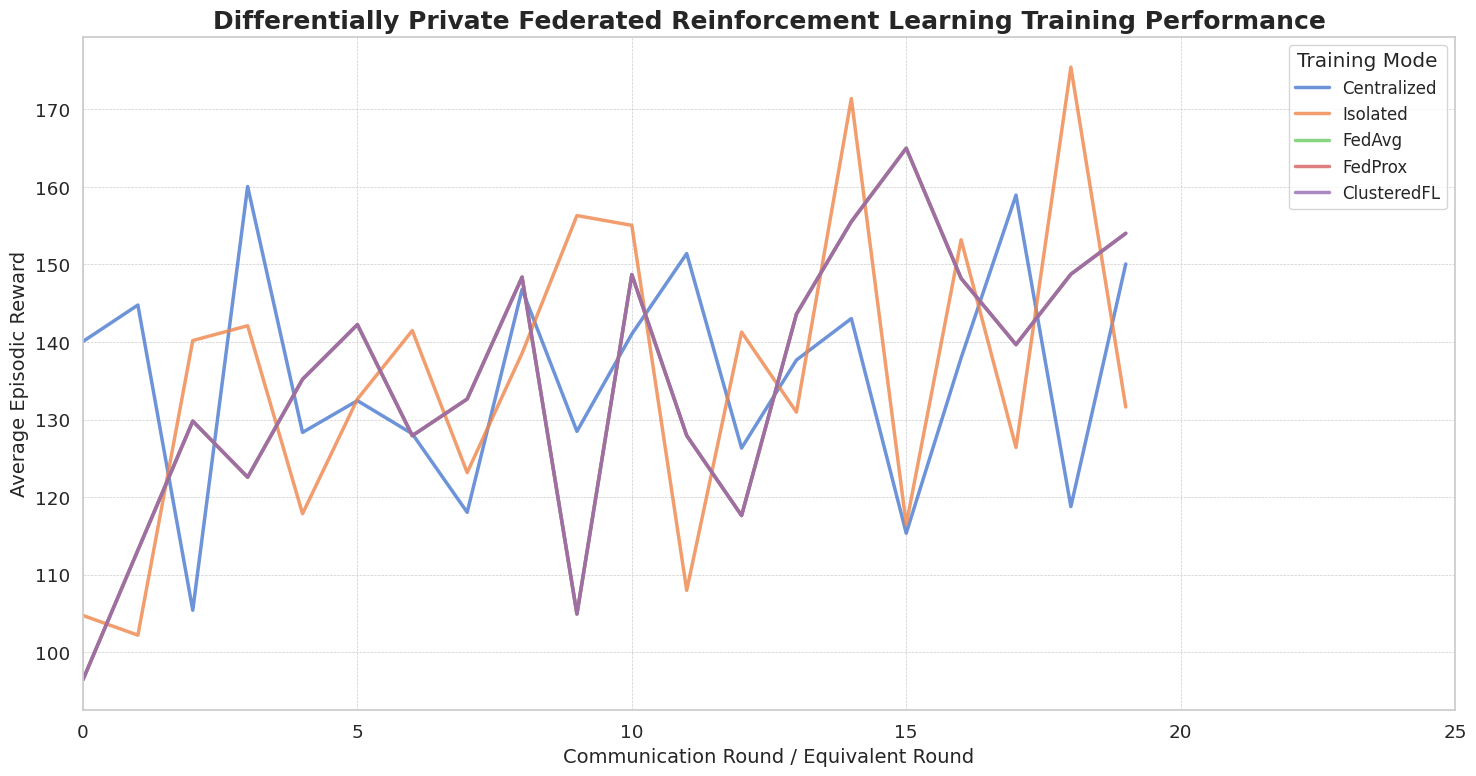

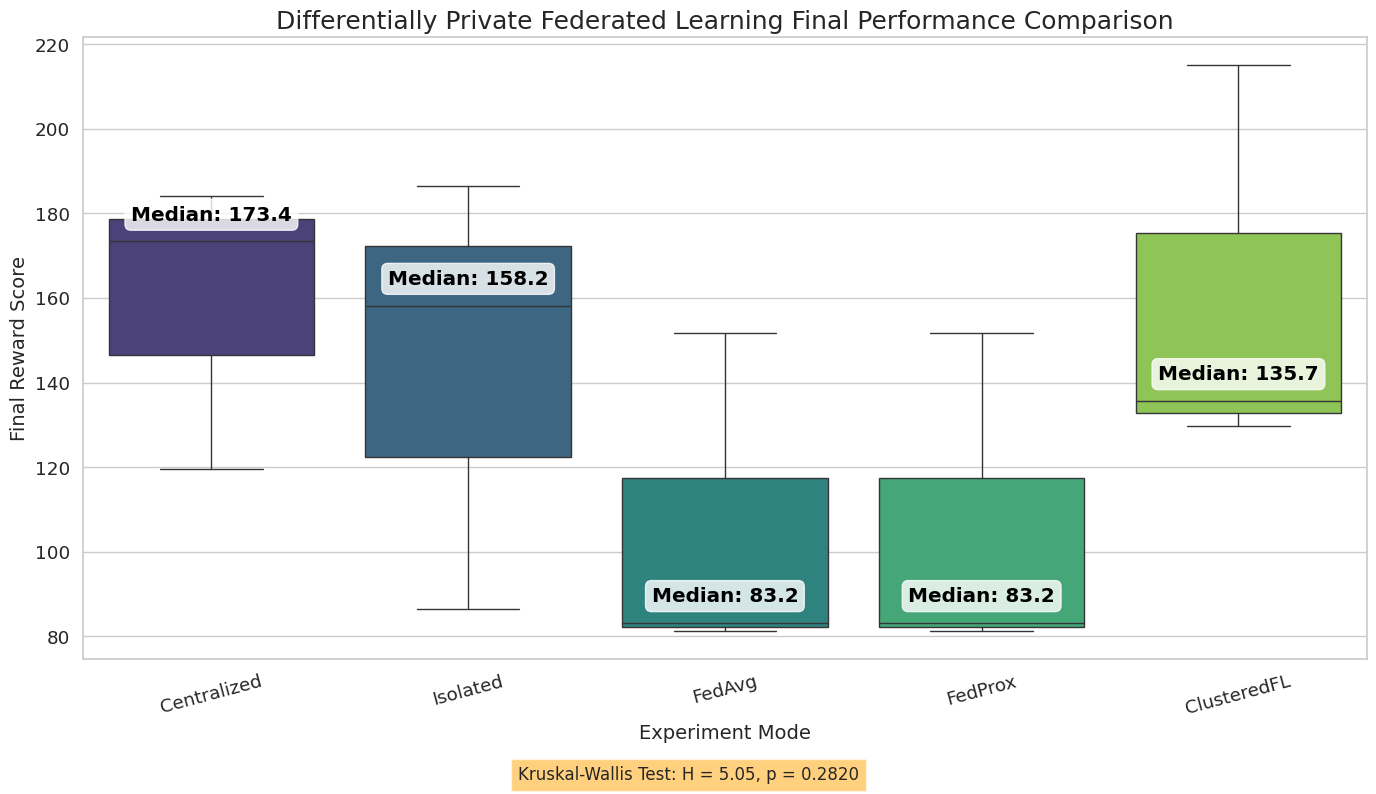

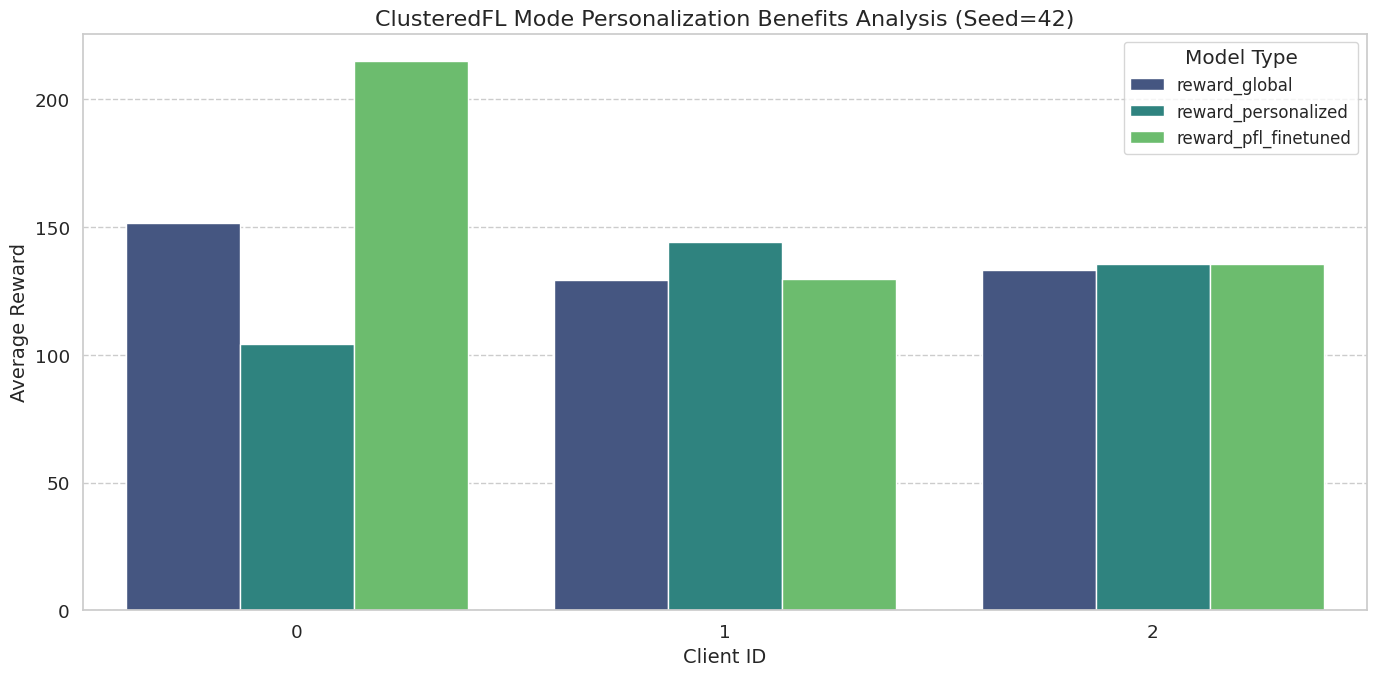

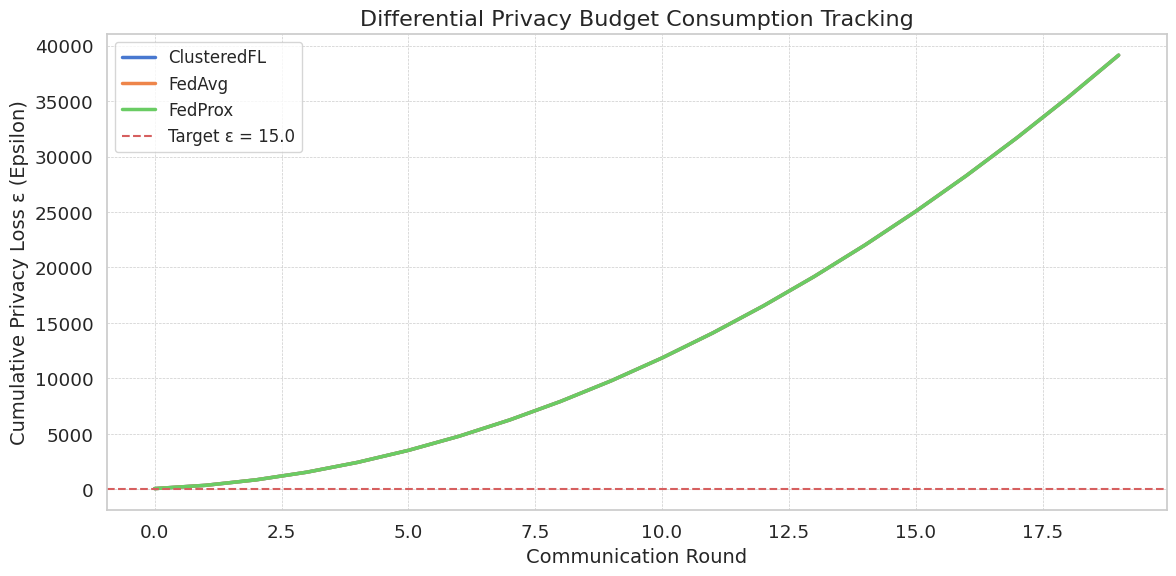

✅ Cell 9: Results Visualization (English Version) completed.
📁 Figures saved to: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_dp_final_stable/figures


In [9]:
# @title Cell 9: 📊 結果視覺化（英文版）
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"❌ Results directory not found: {base_output_dir}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    # Try to load configuration files first
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"🟡 Warning: Failed to read config file: {e}")

    # List found files for debugging
    print(f"🔍 Searching directory: {base_output_dir}")
    if os.path.exists(base_output_dir):
        print(f"📁 Found subdirectories:")
        for item in sorted(os.listdir(base_output_dir)):
            item_path = os.path.join(base_output_dir, item)
            if os.path.isdir(item_path):
                print(f"   📂 {item}")
                for subitem in sorted(os.listdir(item_path)):
                    subitem_path = os.path.join(item_path, subitem)
                    if os.path.isdir(subitem_path):
                        print(f"      📂 {subitem}")
                        csv_files = glob.glob(os.path.join(subitem_path, "*.csv"))
                        for csv_file in csv_files:
                            print(f"         📄 {os.path.basename(csv_file)}")

    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try:
            seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError):
            continue

        for mode_folder in sorted(os.listdir(os.path.join(base_output_dir, seed_folder))):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))

            def read_and_append(file_list, data_list, mode_name, seed_val):
                if not file_list:
                    print(f"🟡 Warning: No files found for {mode_name} (seed {seed_val})")
                    return
                file_path = file_list[0]
                try:
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        df = pd.read_csv(file_path)
                        df['mode'] = mode_name
                        df['seed'] = seed_val
                        data_list.append(df)
                        print(f"✅ Successfully loaded: {mode_name} (seed {seed_val}) - {len(df)} rows")
                    else:
                        print(f"🟡 Warning: File is empty or doesn't exist: {file_path}")
                except Exception as e:
                    print(f"🟡 Warning: Failed to read file: {file_path}, {e}")

            read_and_append(eval_files, all_evals, mode_folder, seed)
            read_and_append(history_files, all_histories, mode_folder, seed)
            read_and_append(privacy_files, all_privacies, mode_folder, seed)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), \
           config_data

# --- Visualization Settings ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_dp_final_stable")  # Match Cell 8 path
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

print(f"🔍 Loading results from: {BASE_OUTPUT_DIR}")
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("❌ No result files found, cannot generate plots. Please ensure Cell 8 has completed successfully.")
    print(f"📁 Expected path: {BASE_OUTPUT_DIR}")
    print(f"📁 Path exists: {os.path.exists(BASE_OUTPUT_DIR)}")
else:
    # Corrected settings to match Cell 8
    SEEDS = [42]  # Only one seed
    mode_order = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]  # Removed Centralized

    print(f"✅ Successfully loaded results from {len(eval_df['seed'].unique()) if not eval_df.empty else 0} runs.")
    if not eval_df.empty:
        print(f"📊 Found modes: {sorted(eval_df['mode'].unique())}")
        print(f"📊 Found seeds: {sorted(eval_df['seed'].unique())}")

    # --- Figure 1: Training History Comparison ---
    if not history_df.empty:
        plt.figure(figsize=(15, 8))

        # Only plot existing modes
        available_modes = [mode for mode in mode_order if mode in history_df['mode'].unique()]

        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=available_modes, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)

        plt.title('Differentially Private Federated Reinforcement Learning Training Performance', fontsize=18, weight='bold')
        plt.xlabel('Communication Round / Equivalent Round', fontsize=14)
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xlim(0, 25)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_dp_eng.png'), dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("🟡 Warning: No training history data found")

    # --- Figure 2: Final Performance Comparison ---
    if not eval_df.empty:
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'Final Reward Score'})
        available_modes = [mode for mode in mode_order if mode in eval_to_plot['mode'].unique()]

        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=available_modes, palette="viridis")

        # Add median annotations
        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(available_modes)
        for xtick in ax.get_xticks():
            if xtick < len(available_modes):
                mode_name = available_modes[xtick]
                median_val = medians.get(mode_name)
                if pd.notna(median_val):
                    ax.text(xtick, median_val + 5, f'Median: {median_val:.1f}',
                            horizontalalignment='center', size='medium',
                            color='black', weight='semibold',
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.title('Differentially Private Federated Learning Final Performance Comparison', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score', fontsize=14)
        plt.xticks(rotation=15)

        # Statistical testing
        groups = [eval_to_plot['Final Reward Score'][eval_to_plot['mode'] == m].dropna()
                 for m in available_modes if m in eval_to_plot['mode'].unique()]
        if len(groups) > 1:
            h_stat, p_value = stats.kruskal(*groups)
            plt.figtext(0.5, 0.01, f'Kruskal-Wallis Test: H = {h_stat:.2f}, p = {p_value:.4f}',
                        ha='center', fontsize=12,
                        bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.tight_layout(rect=[0, 0.03, 1, 1])
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_dp_eng.png'), dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("🟡 Warning: No evaluation results data found")

    # --- Figure 3: Personalization Benefit Analysis ---
    if not eval_df.empty:
        first_seed = SEEDS[0]
        # Prefer ClusteredFL, otherwise use the first available mode
        if 'ClusteredFL' in eval_df['mode'].unique():
            target_mode = 'ClusteredFL'
        else:
            target_mode = eval_df['mode'].unique()[0]

        target_eval = eval_df[(eval_df['mode'] == target_mode) & (eval_df['seed'] == first_seed)]

        if not target_eval.empty:
            target_melted = target_eval.melt(
                id_vars=['client_id'],
                value_vars=['reward_global', 'reward_personalized', 'reward_pfl_finetuned'],
                var_name='Model Type', value_name='Average Reward'
            )

            plt.figure(figsize=(14, 7))
            sns.barplot(data=target_melted, x='client_id', y='Average Reward',
                       hue='Model Type', palette='viridis')

            plt.title(f'{target_mode} Mode Personalization Benefits Analysis (Seed={first_seed})', fontsize=16)
            plt.xlabel('Client ID', fontsize=14)
            plt.ylabel('Average Reward', fontsize=14)
            plt.legend(title='Model Type', fontsize=12)
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()

            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit_dp_eng.png'), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print(f"🟡 Warning: No data found for {target_mode} mode")

    # --- Figure 4: Privacy Cost Tracking ---
    if not privacy_df.empty:
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(['FedAvg', 'FedProx', 'ClusteredFL'])]

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=privacy_to_plot, x='round', y='cumulative_epsilon', hue='mode',
                         errorbar=('sd', 1), linewidth=2.5)

            # Add target epsilon line
            if loaded_config and 'dp_target_epsilon' in loaded_config:
                target_eps = loaded_config['dp_target_epsilon']
                plt.axhline(y=target_eps, color='r', linestyle='--',
                           label=f'Target ε = {target_eps}')
            else:
                # If no config file, use Cell 8 default
                target_eps = 15.0
                plt.axhline(y=target_eps, color='r', linestyle='--',
                           label=f'Target ε = {target_eps}')

            plt.title('Differential Privacy Budget Consumption Tracking', fontsize=16)
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel('Cumulative Privacy Loss ε (Epsilon)', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_dp_eng.png'), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("🟡 Warning: No privacy cost data found")
    else:
        print("🟡 Warning: No privacy cost files found")

print("✅ Cell 9: Results Visualization (English Version) completed.")
print(f"📁 Figures saved to: {FIGURES_OUTPUT_DIR}")


### 接下來
* 擴展客戶端數量研究